### Visualizing the distribution of the observations

### Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12249
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     14.9| 30.4132| -86.6635|       PRCP|US1FLOK0014|    38|[00 00 00 00 B0 5...|2009.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     5|[40 5A F0 5A 80 5...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     3|[20 5B 78 5B 48 5...|2000.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    40|[90 55 E0 54 A0 5...|2001.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|    12|[E0 54 30 54 30 5...|2002.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00015483')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00015483'
8 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      3.0| 30.6833| -88.0333|       TOBS|USC00015483|     1|[80 51 40 CC 00 0...|1958.0|BSSSBSBS|
|      3.0| 30.6833| -88.0333|       TOBS|USC00015483|     0|[30 55 30 54 80 5...|1959.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(8, 365)

In [4]:
temp1=np.nanmean(T,axis=0)
temp1=((temp1/10.)+32)*1.88

In [5]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00017733')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T2=np.vstack(rows)
T2=T2/10.  # scaling to make the temperature be in centingrates
shape(T2)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00017733'
14 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     54.9|    30.7| -88.1667|       TOBS|USC00017733|    30|[90 59 40 5A 98 5...|1907.0|BSSSBSBS|
|     54.9|    30.7| -88.1667|       TOBS|USC00017733|    48|[A0 57 A0 57 00 7...|1908.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(14, 365)

In [6]:
temp2=np.nanmean(T2,axis=0)
temp2=((temp2/10.)+32)*1.88

In [7]:
temp=[]
temp.append(temp1)
temp.append(temp2)
temp

[array([ 61.375  ,  61.21875,  61.375  ,  61.28125,  61.5    ,  61.5625 ,
         61.5625 ,  61.5    ,  61.15625,  60.8125 ,  60.96875,  61.4375 ,
         61.28125,  61.625  ,  61.625  ,  60.625  ,  60.75   ,  61.21875,
         61.875  ,  61.6875 ,  61.28125,  61.21875,  61.875  ,  61.4375 ,
         61.15625,  62.21875,  61.4375 ,  61.15625,  61.34375,  61.90625,
         61.6875 ,  61.75   ,  61.6875 ,  61.28125,  61.34375,  61.90625,
         61.875  ,  61.90625,  61.5625 ,  61.96875,  62.09375,  61.90625,
         61.6875 ,  61.625  ,  61.5    ,  61.6875 ,  61.4375 ,  61.6875 ,
         62.09375,  61.4375 ,  61.21875,  62.15625,  61.8125 ,  61.96875,
         62.375  ,  61.625  ,  61.96875,  62.09375,  62.6875 ,  62.15625,
         62.15625,  62.21875,  62.15625,  62.21875,  61.5625 ,  62.15625,
         62.28125,  62.75   ,  62.21875,  62.6875 ,  62.5625 ,  62.625  ,
         62.625  ,  62.5625 ,  62.4375 ,  62.6875 ,  62.5    ,  62.375  ,
         62.15625,  62.21875,  62.0937

### Script for plotting yearly plots

/Users/laurawilke/anaconda3/envs/py27_2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


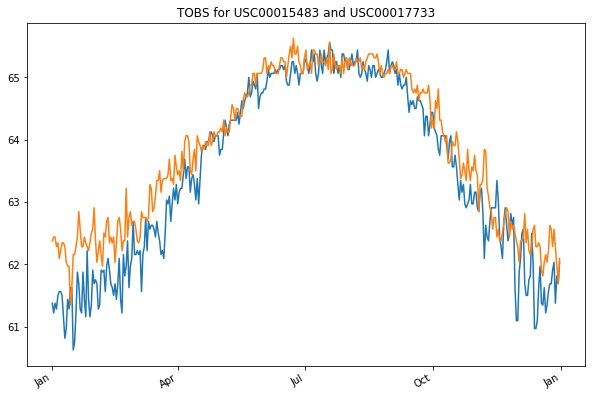

In [8]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(temp[0].transpose(),fig,ax,title='TOBS for USC00015483 and USC00017733')
YP.plot(temp[1].transpose(),fig,ax,title='TOBS for USC00015483 and USC00017733')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/yoavfreund/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


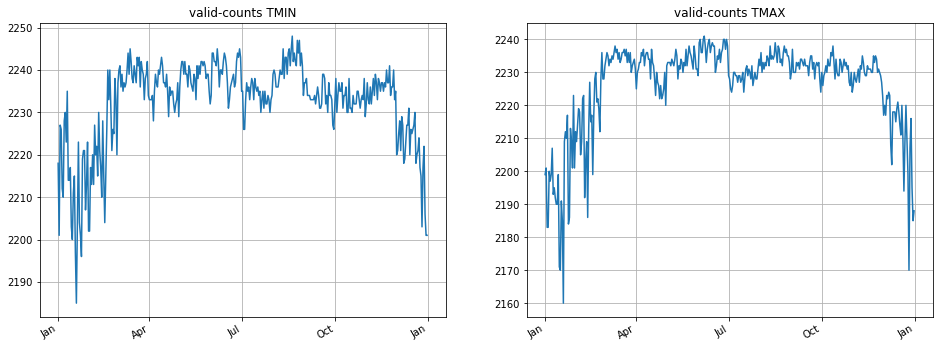

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

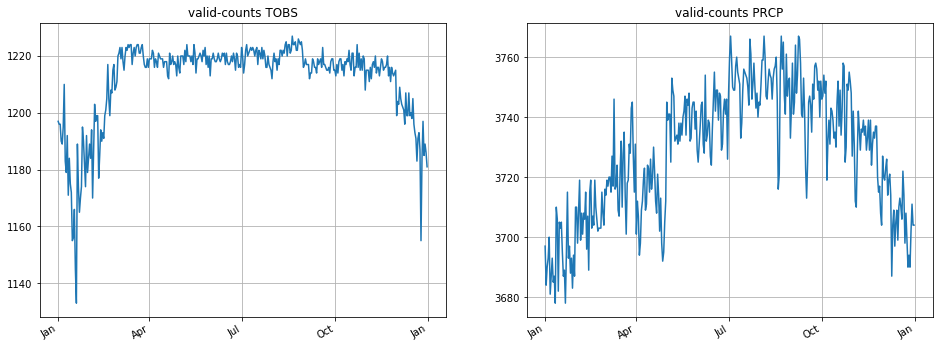

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

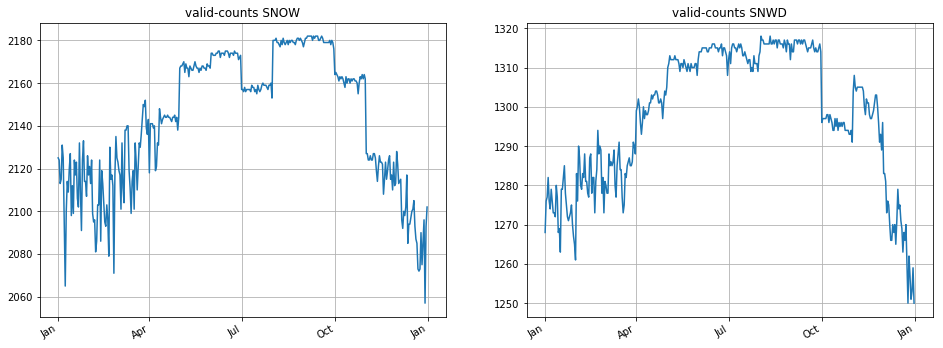

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

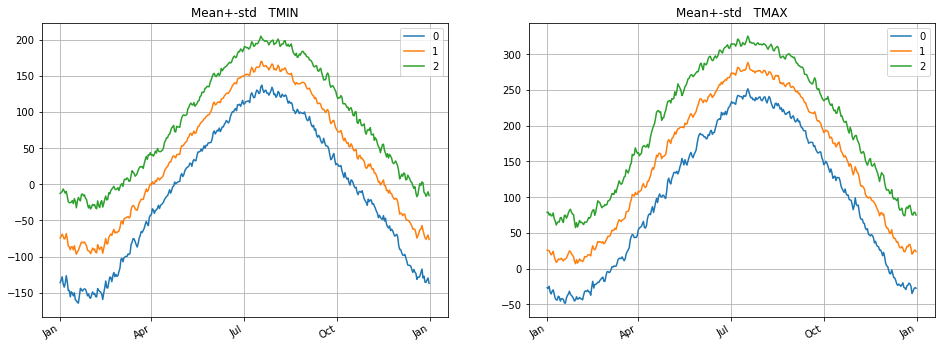

In [9]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

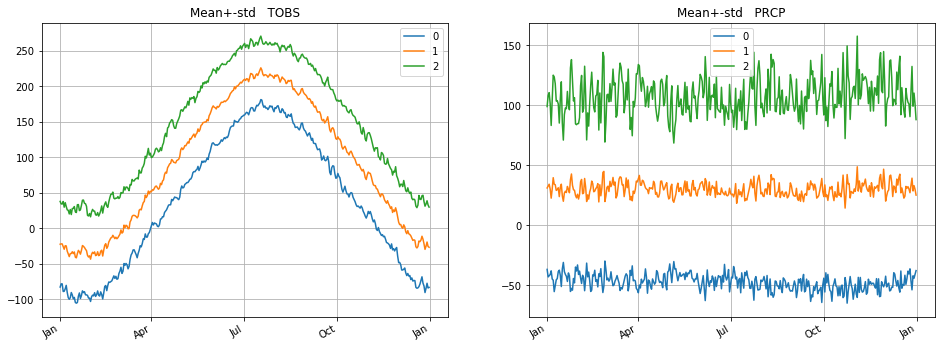

In [10]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

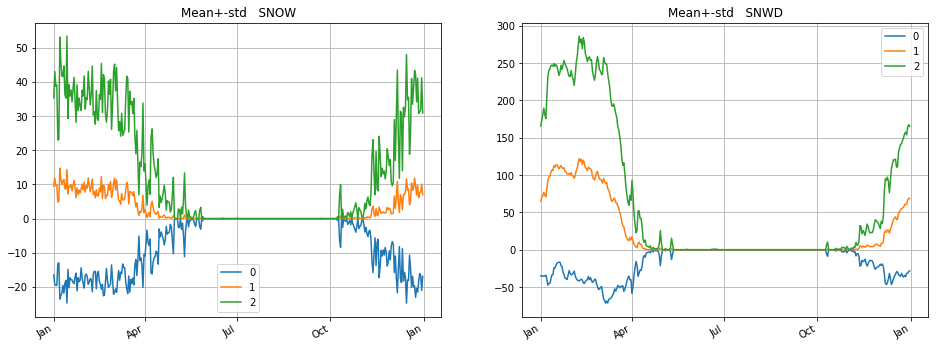

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

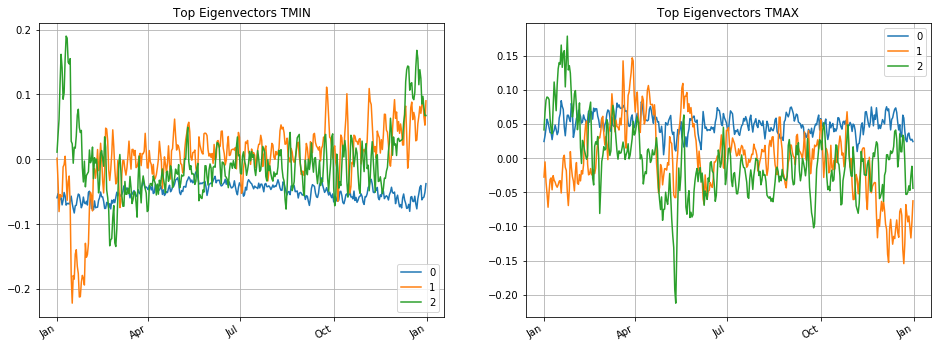

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

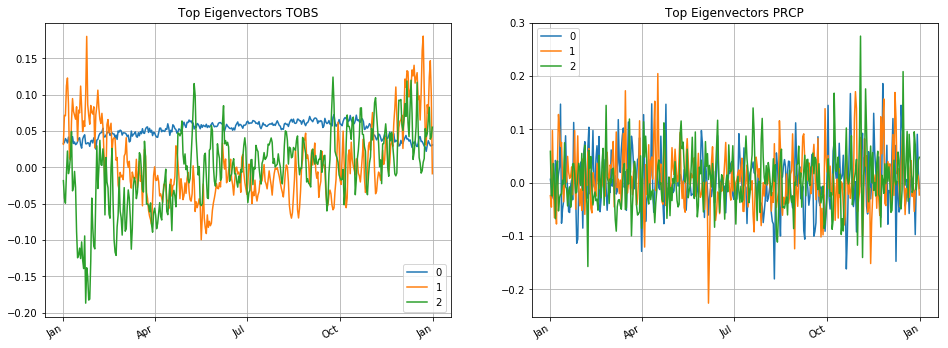

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

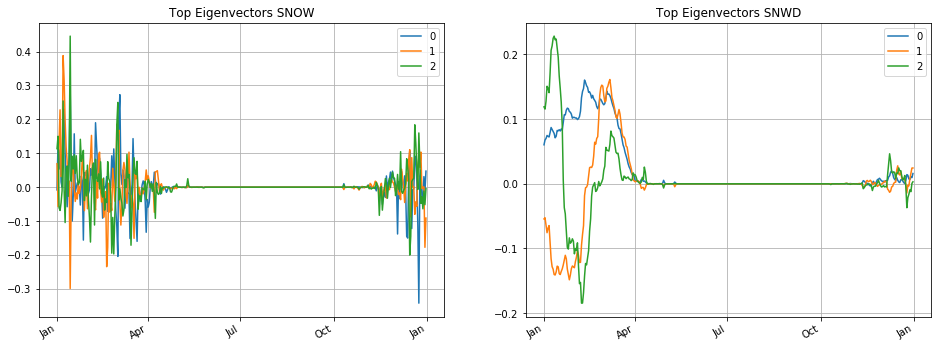

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

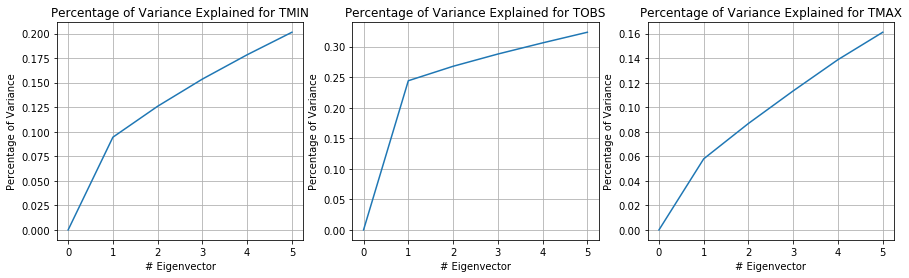

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

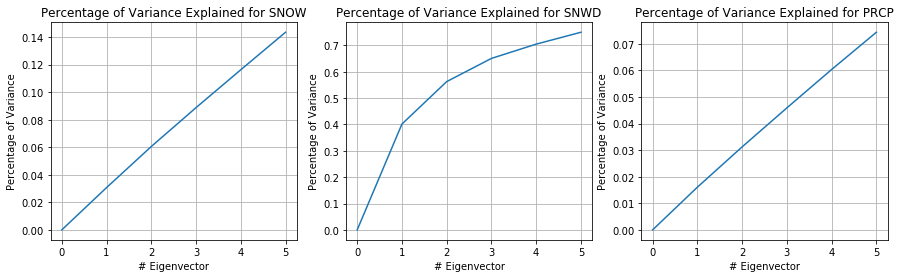

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()